# Introduction to atomman: Dislocation analysis tools

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 

## 1. Introduction

This Notebook describes the analysis tools contained in atomman.defect for finding and characterizing dislocations.

**Library Imports**

In [1]:
# Standard Python libraries
from copy import deepcopy
import datetime

# http://www.numpy.org/
import numpy as np

# https://matplotlib.org/
import matplotlib.pyplot as plt
%matplotlib inline

# https://github.com/usnistgov/atomman
import atomman as am
import atomman.unitconvert as uc

# Show atomman version
print('atomman version =', am.__version__)

# Show date of Notebook execution
print('Notebook executed on', datetime.date.today())

atomman version = 1.3.4
Notebook executed on 2020-09-15


## 1.1. Load atomic systems

A system containing a single Al $\frac{a}{2}$<111> edge dislocation was created by

1. Building a defect-free system where the crystal has been rotated for the dislocation solution.

2. Using solve_volterra_dislocation to obtain an elastic solution for a perfectly straight dislocation.

3. Inserting a dislocation into the defect-free system by shifting the atoms according to the elastic solution's displacements. 

4. Performing a short low temerature anneal and energy minimization to relax the atomic configuration.  During relaxation, the system is kept periodic along the dislocation line, but is non-periodic in the other two directions.  Atoms at the edge of the non-periodic directions are held fixed.

All atomic dislocation analysis tools identify and characterize the presence of defects in an atomic system by comparing the local atomic environment around every atom to a reference state. Some of the tools in atomman do this by directly mapping each atom in the defect system to a corresponding defect-free base system. In creating a dislocation as listed above, the system constructed in step #1 serves this purpose.

In [2]:
base_system = am.load('atom_dump', 'files/fcc_Al_base.dump')
disl_system = am.load('atom_dump', 'files/fcc_Al_disl.dump')

The dislocation system is oriented with the line direction parallel to the x-axis and the slip plane perpendicular to the z-axis.  As such, the Burgers vector of the full edge dislocation is entirely in the y direction.

In [3]:
alat = uc.set_in_units(4.05, 'Å')
burgers = np.array([0.0, alat / 2**0.5, 0.0])
burgers

array([0.        , 2.86378246, 0.        ])

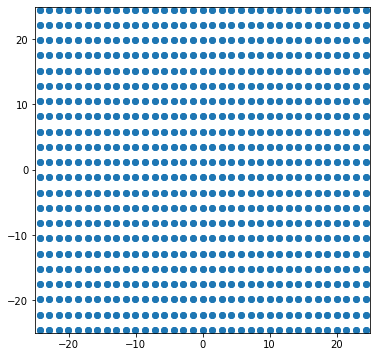

In [4]:
# plot original positions of atoms in system
fig = plt.figure(figsize=(6,6))
plt.plot(base_system.atoms.pos[:, 1], base_system.atoms.pos[:, 2], 'o')
plt.xlim([-25, 25])
plt.ylim([-25, 25])
plt.show()

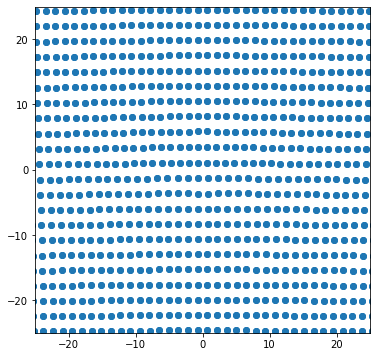

In [5]:
# plot positions of atoms in dislocation system
fig = plt.figure(figsize=(6,6))
plt.plot(disl_system.atoms.pos[:, 1], disl_system.atoms.pos[:, 2], 'o')
plt.xlim([-25, 25])
plt.ylim([-25, 25])
plt.show()

## 2. Slip vector

The slip vector is useful for characterizing the path that dislocations have moved between a current state and a reference state.  It characterizes how much crystal slip happens between every atom and their nearest neighbors.  The burgers vector of any moving dislocation can be estimated by looking at the magnitude and direction of the slip vector of any atoms that the dislocation passed by. The slip vector was originally outlined in [Zimmerman, et. al, Phys Rev Lett 87, 165507 ](http://dx.doi.org/10.1103/PhysRevLett.87.165507).

$$ S_{i \alpha} = -\sum_{\beta=1}^{n_{\alpha}} {\left( x_{i \alpha \beta} - X_{i \alpha \beta} \right)} $$

where $n_{\alpha}$ is the number of nearest neighbor atoms $\beta$ of atom $\alpha$, $x_{i \alpha \beta}$ is the vector difference between atoms $\alpha$ and $\beta$ in the current configuration, and $X_{i \alpha \beta}$ is the vector difference between atoms $\alpha$ and $\beta$ in the reference configuration.  

**Note 1**: To be general with any crystal and dislocation, the slip vector computed here is *not* scaled by the number of slipped neighbors like it is in the original formulation. This means that the value of the slip vector returned will be a multiple of the Burgers vector that caused the slip.  To estimate the Burgers vector of a dislocation that moved along a slip plane, the slip vector value needs to be divided by the total number of neighbor atoms that are across the slip plane.

**Note 2**: The reference system does not need to be of a perfect crystal and can simply be an earlier state.  With this choice, the slip vector will reveal the slip deformation that occured between the two states of the system.  This can be useful for identifying how dislocations move in highly deformed/defective systems.

### 2.1 slip_vector()

Parameters
    
- **system_0** (*atomman.system*) The base/reference system to use.

- **system_1** (*atomman.system*) The defect/current system to use.

- **neighbors** (*atomman.NeighborList, optional*) The neighbor list associated with system_0 to use.  Either neighbors or cutoff must be given, or system_0 must have a neighbors attribute.

- **cutoff** (*float, optional*) Cutoff distance for computing a neighbor list for system_0.  Either neighbors or cutoff must be given, or system_0 have a neighbors attribute.
    
Returns
    
- (*numpy.ndarray*) The computed slip vectors.

In [6]:
# Make reference system's pbc match defect system's pbc
# This avoids free surfaces having large slip vectors
base_system.pbc = (True, False, False)

# Build the neighbor list using the reference system
neighbors0 = base_system.neighborlist(cutoff=0.9*alat)

# Compute the slip vector for all atoms
slip = am.defect.slip_vector(base_system, disl_system, neighbors=neighbors0)

As the reference system is the defect free system used to construct the dislocation system, the slip vector computed here shows the dislocation slip needed to insert the dislocation into the system.  Note that the slip vector values on the two sides of the plane are equal but opposite.

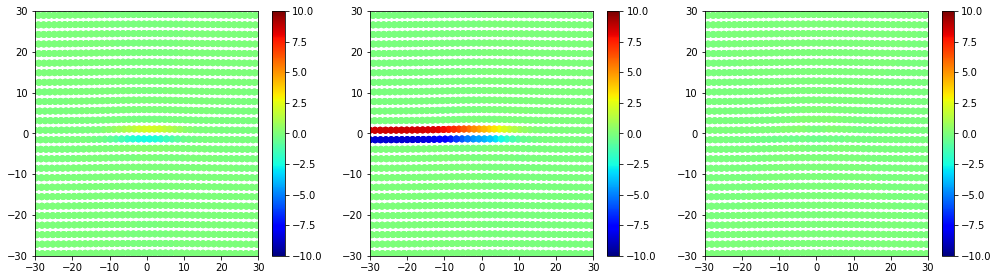

In [7]:
# plot slip vector components for all atoms
fig, ax = plt.subplots(ncols=3, figsize=(17,4.5))
im = ax[0].scatter(disl_system.atoms.pos[:, 1], disl_system.atoms.pos[:, 2], c=slip[:, 0], vmin=-10, vmax=10, cmap='jet')
plt.colorbar(im, ax=ax[0])
ax[0].set_xlim(-30, 30)
ax[0].set_ylim(-30, 30)

im = ax[1].scatter(disl_system.atoms.pos[:, 1], disl_system.atoms.pos[:, 2], c=slip[:, 1], vmin=-10, vmax=10, cmap='jet')
plt.colorbar(im, ax=ax[1])
ax[1].set_xlim(-30, 30)
ax[1].set_ylim(-30, 30)

im = ax[2].scatter(disl_system.atoms.pos[:, 1], disl_system.atoms.pos[:, 2], c=slip[:, 2], vmin=-10, vmax=10, cmap='jet')
plt.colorbar(im, ax=ax[2])
ax[2].set_xlim(-30, 30)
ax[2].set_ylim(-30, 30)

plt.show()

The Burgers vector for the dislocation can then be estimated from slip vector values for atoms along the slipped plane.  

In [8]:
# Find atoms with coordinates -30 < y < -25 and 0.0 < z < 3.0 and 
matches = ((disl_system.atoms.pos[:, 1] > -30.0) & (disl_system.atoms.pos[:, 1] < -25.0)
          &(disl_system.atoms.pos[:, 2] > 0.0) & (disl_system.atoms.pos[:, 2] < 3.0))

# Get average slip for the atoms
aveslip = slip[matches].mean(axis=0)

# Divide the slip by 3 to estimate the Burgers vector
# as fcc (111) planes have three cross-plane neighbors
burgers_est = aveslip / 3

print(f'actual Burgers vector:    [{burgers[0]: 7.4f}, {burgers[1]: 7.4f}, {burgers[2]: 7.4f}]')
print(f'estimated Burgers vector: [{burgers_est[0]: 7.4f}, {burgers_est[1]: 7.4f}, {burgers_est[2]: 7.4f}]')

actual Burgers vector:    [ 0.0000,  2.8638,  0.0000]
estimated Burgers vector: [-0.0016,  2.8662,  0.0060]


Try estimating the partial dislocation by looking at slip in the stacking fault area

In [9]:
# Find atoms with coordinates -1 < y < 1 and 0.0 < z < 3.0 and 
matches = ((disl_system.atoms.pos[:, 1] > -1.0) & (disl_system.atoms.pos[:, 1] < 1.0)
          &(disl_system.atoms.pos[:, 2] > 0.0) & (disl_system.atoms.pos[:, 2] < 3.0))

# Get average slip for the atoms
aveslip = slip[matches].mean(axis=0)

# Divide the slip by 3 to estimate the Burgers vector
# as fcc (111) planes have three cross-plane neighbors
burgers_est = aveslip / 3

# Define the Shockley Burgers vector relative to the system definintion
shockley = alat * np.array([ 6**0.5 / 12, 2**0.5 / 4, 0.0])

print(f'actual Burgers vector:    [{shockley[0]: 7.4f}, {shockley[1]: 7.4f}, {shockley[2]: 7.4f}]')
print(f'estimated Burgers vector: [{burgers_est[0]: 7.4f}, {burgers_est[1]: 7.4f}, {burgers_est[2]: 7.4f}]')

actual Burgers vector:    [ 0.8267,  1.4319,  0.0000]
estimated Burgers vector: [ 0.7035,  1.4935, -0.0257]


## 3. Disregistry

The disregistry, $\delta_i$ characterizes the planar spreading of a dislocation in direction $\xi$ along a slip plane by measuring the difference in the displacements between the atomic planes of atoms just above, $u_i^+$, and below, $u_i^-$, the mathematical slip plane.  The displacements are taken relative to a perfect crystal base configuration.

$$ \delta_i(\xi) = u_i^+(\xi) - u_i^-(\xi)$$

The algorithm used by atomman does the following:

1. Uses the base configuration to identify all atoms in the two atomic planes neighboring the slip plane.

2. For all atoms identified in #1, finds the unique $\xi$ coordinates from the base configuration and computes $u_i^+$ and $u_i^-$ for the defect configuration relative to the base configuration.

3. Any $u_i^+$ or $u_i^-$ corresponding to the same $\xi$ coordinates are averaged, and the values of $u_i^+$ and $u_i^-$ are linearly interpolated to all unique $\xi$ coordinates. This is done as the $\xi$ coordinates may differ for the two atomic planes. 

4. The disregistry is computed for all unique $\xi$ coordinates by finding the difference in the interpolated $u_i^+$ and $u_i^-$ displacements.

### 3.1 disregistry()

Parameters

- **basesystem** (*atomman.System*) A perfect reference system with atoms directly corresponding to atoms in dislsystem.

- **dislsystem** (*atomman.System*) A dislocation-containing system.

- **m** (*array-like object, optional*) Unit vector defining the direction associated with the planar spreading along the slip plane.  Default value is [1, 0, 0] (Cartesian x-coordinates).

- **n** (*array-like object, optional*) Unit vector defining the normal to the slip plane.  Must be perpendicular to xvector.  Default value is [0, 1, 0] (Cartesian y-axis).

- **planepos** (*array-like object, optional*) A position on the slip plane so that the plane can be fully defined.  The slip plane position should fall between two planes of atoms.  Default value is [0,0,0].
    
Returns
   
- **coord** (*numpy.ndarray*) The (N,) array of unique coordinates (atomic columns) neighboring the slip plane.

- **disregistry** (*numpy.ndarray*) A (N, 3) array of the dislocation's disregistry at each x.

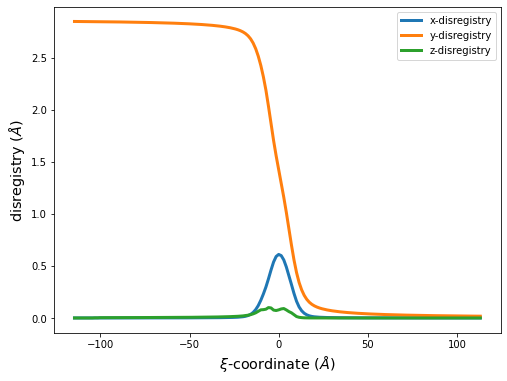

In [10]:
xi, disreg = am.defect.disregistry(base_system, disl_system, m=[0,1,0], n=[0,0,1])

fig = plt.figure(figsize=(8,6))

plt.plot(xi, disreg[:, 0], label='x-disregistry', linewidth=3)
plt.plot(xi, disreg[:, 1], label='y-disregistry', linewidth=3)
plt.plot(xi, disreg[:, 2], label='z-disregistry', linewidth=3)

plt.xlabel('$\\xi$-coordinate ($\AA$)', size='x-large')
plt.ylabel('disregistry ($\AA$)', size='x-large')
plt.legend(fontsize='xx-large')

plt.legend()
plt.show()

## 3. Nye tensor

The nye_tensor() function computes per-atom strain states and Nye tensors by comparing the local environment around each atom in a defect system to corresponding local environments in defect-free systems.  The algorithm used here follows the one outlined in [Hartley, C. & Mishin, Y. (2005). Acta Materialia 53, 1313-1321.](http://dx.doi.org/10.1016/j.actamat.2004.11.027) and [Hartley, C. S. & Mishin, Y. (2005). Materials Science and Engineering: A 400-401, 18-21.](http://dx.doi.org/10.1016/j.msea.2005.03.076), as well as code obtained from Yuri Mishin. 

The local environment around each atom $\alpha$ is characterized using a list of the position vector differences between the atom and all neighboring atoms within a cutoff distance.

- $p_{i \alpha \beta}$ is the vector difference in the defect-free reference system between atom $\alpha$ and a neighboring atom identified in the reference system, $\beta$.

- $q_{i \alpha \gamma}$ is the vector difference in the defect system between atom $\alpha$ and a neighboring atom identified in the defect system, $\gamma$.

The list of $\beta$ and $\gamma$ neighbors may differ, so $p_{i \alpha \gamma}$ vectors must be identified by uniquely pairing as many of the $p_{i \alpha \beta}$ vectors to $q_{i \alpha \gamma}$ vectors based on their directions and magnitudes.  Using the pairs, a strain correspondence tensor, $G_{ij \alpha}$, is computed as a least squares solution of the linear matrix equation

$$ q_{i \alpha \gamma} = p_{j \alpha \gamma} G_{ij \alpha}$$

Various strain properties can then be computed using $G_{ij \alpha}$:

- strain state

$$ E_{ij \alpha} = \frac{(\delta_{ij} - G_{ij \alpha}) + (\delta_{ij} - G_{ji \alpha})}{2} $$

- strain invariants

$$ I_{1 \alpha} = E_{11 \alpha} + E_{22 \alpha} + E_{33 \alpha} $$
    
$$ I_{2 \alpha} = E_{11 \alpha} E_{22 \alpha} + E_{11 \alpha} E_{33 \alpha} + E_{22 \alpha} E_{33 \alpha} - E_{12 \alpha}^2 - E_{13 \alpha}^2 - E_{23 \alpha}^2 $$
    
$$ I_{3 \alpha} = \det{E_{ij \alpha}} $$
    
- angular velocity

$$ R_{ij \alpha} = \frac{(\delta_{ij} - G_{ij \alpha}) - (\delta_{ij} - G_{ji \alpha})}{2} $$
    
$$ \omega_{\alpha} = \sqrt{R_{12 \alpha}^2 + R_{13 \alpha}^2 + R_{23 \alpha}^2} $$

The Nye tensor, $N_{ij \alpha}$, is related to $G_{i j \alpha}$ as

$$ N_{km \alpha} = - \epsilon_{ijk} \partial_i G_{m j \alpha} $$

The derivatives of $G_{i j \alpha}$ are obtained numerically by comparing the change in the strain correspondence tensor between each atom $\alpha$ and its neighbors $\gamma$. A single value for each deriviative is obtained by least squares fits of the following equations 

$$ G_{i j \gamma} - G_{i j \alpha} = q_{k \alpha \gamma} \partial_k G_{i j \alpha} $$


__Note__ that the equations in the original papers on the atomistic Nye tensor method had a typo with indicies. This function has been verified as producing comparable results as the original calculation code used by the authors.    

### 3.1. Define p_vectors

The Nye tensor calculation requires a list of reference radial neighbor vectors for each atom. For best results, these should correspond to a perfect crystal in the same/similar orientation as the defect system being analyzed.

- If all atom sites in the perfect crystal are symmetrically equivalent, then only one set of p_vectors is needed and is used for all atoms.

- Otherwise, a p_vector list needs to be specified for each atom individually based on its perfect crystal site.

Some examples:

- Body-centered cubic and face-centered cubic cells only have atoms occupying one unique lattice site.

- Hexagonal close packed has two unique sites. With A/B basal plane stacking, all atoms in A planes are identical sites and all atoms in B planes are identical sites. 

- Diamond cubic likewise has two unique sites: the face-centered cubic sites, and the sites in between.

In [11]:
# Define p_vectors for fcc cubic (standard reference frame)
p_vectors = alat * np.array([[ 0.5, 0.5, 0.0], [ 0.5, 0.0, 0.5], [ 0.0, 0.5, 0.5],
                             [-0.5, 0.5, 0.0], [-0.5, 0.0, 0.5], [ 0.0,-0.5, 0.5],
                             [ 0.5,-0.5, 0.0], [ 0.5, 0.0,-0.5], [ 0.0, 0.5,-0.5],
                             [-0.5,-0.5, 0.0], [-0.5, 0.0,-0.5], [ 0.0,-0.5,-0.5]])

print(p_vectors)

[[ 2.025  2.025  0.   ]
 [ 2.025  0.     2.025]
 [ 0.     2.025  2.025]
 [-2.025  2.025  0.   ]
 [-2.025  0.     2.025]
 [ 0.    -2.025  2.025]
 [ 2.025 -2.025  0.   ]
 [ 2.025  0.    -2.025]
 [ 0.     2.025 -2.025]
 [-2.025 -2.025  0.   ]
 [-2.025  0.    -2.025]
 [ 0.    -2.025 -2.025]]


The p_vectors must be transformed to match the orientation of the defect system. This can either be done before calling nye_tensor() as shown here, or by using the axes parameter of the nye_tensor() function.

In [12]:
# Define the transformation matrix
xaxis = [-1,-1, 2]
yaxis = [ 1,-1, 0]
zaxis = [ 1, 1, 1]
transform = am.tools.axes_check([xaxis, yaxis, zaxis])

# Transformed p_vectors
trans_p_vectors = np.inner(p_vectors, transform)
trans_p_vectors[np.isclose(trans_p_vectors, 0)] = 0.0
print(trans_p_vectors)

[[-1.65340558  0.          2.33826859]
 [ 0.82670279  1.43189123  2.33826859]
 [ 0.82670279 -1.43189123  2.33826859]
 [ 0.         -2.86378246  0.        ]
 [ 2.48010836 -1.43189123  0.        ]
 [ 2.48010836  1.43189123  0.        ]
 [ 0.          2.86378246  0.        ]
 [-2.48010836  1.43189123  0.        ]
 [-2.48010836 -1.43189123  0.        ]
 [ 1.65340558  0.         -2.33826859]
 [-0.82670279 -1.43189123 -2.33826859]
 [-0.82670279  1.43189123 -2.33826859]]


### 3.2 nye_tensor_p()
For convenience, the atomman.defect.nye_tensor_p() function can be used to generate p_vector lists for all atoms using a base reference system.  The reference system should directly correspond to the system that the nye_tensor() calculation will be performed on, but be a perfect defect-free crystal with all periodic boundaries.

Parameters
   
- **system** (*atomman.system*) The base/reference system to use.  This should be a defect-free  perfect crystal system with atom ids directly corresponding to atoms in any system that you want to analyze with the Nye tensor.

- **neighbors** (*atomman.NeighborList, optional*) The neighbor list associated with system to use.  Either neighbors or cutoff must be given, or system must have a neighbors attribute.

- **cutoff** (*float, optional*) Cutoff distance for computing a neighbor list for system.  Either neighbors or cutoff must be given, or system have a neighbors attribute.
    
Returns

- (*numpy.ndarray*) The list of p distance vectors for each atom in system.

In [13]:
# Make reference system's pbc all periodic
base_system.pbc = (True, True, True)

# Build p_vectors
neighbors0 = base_system.neighborlist(cutoff=alat*0.9)
all_p_vectors = am.defect.nye_tensor_p(base_system, neighbors=neighbors0)

# Show length of all_p_vectors to be natoms
print(base_system.natoms)
print(len(all_p_vectors))

# Show that first p_vectors list matches p_vectors above, besides order
first_p_vectors = all_p_vectors[0]
first_p_vectors[np.isclose(first_p_vectors, 0)] = 0.0
print(first_p_vectors)

32640
32640
[[ 0.          2.86378576  0.        ]
 [-2.48011122  1.43189288  0.        ]
 [ 2.48011122 -1.43189288  0.        ]
 [ 2.48011122  1.43189288  0.        ]
 [ 1.65340748  0.         -2.33827128]
 [-0.82670374 -1.43189288 -2.33827128]
 [-0.82670374  1.43189288 -2.33827128]
 [ 0.         -2.86378576  0.        ]
 [-2.48011122 -1.43189288  0.        ]
 [-1.65340748  0.          2.33827128]
 [ 0.82670374  1.43189288  2.33827128]
 [ 0.82670374 -1.43189288  2.33827128]]


### 3.3 nye_tensor()

Parameters
    
- **system** (*atomman.System*) The atomic system to compute the per-atom strain properties and Nye tensor for.

- **p_vectors** (*array-like object*) List(s) of radial distance vectors between each atom and its nearest neighbors in a perfect crystal setting.  If one list of p_vectors is given, then it is applied to all atoms.

- **theta_max** (*float, optional*) The maximum theta angle in degrees to use when searching for matches between p vectors and q vectors.  Optimum values are dependent on the crystal structure. Default value is 27, which is the original value used for fcc crystals.

- **axes** (*array-like object, optional*) 3x3 array of right-handed orthogonal axes.  If given, will be used to transform the p_vectors before computing the Nye tensor.

- **neighbors** (*atomman.NeighborList, optional*) The neighbor list associated with system to use.  Either neighbors or cutoff must be given, or system must have a neighbors attribute.

- **cutoff** (*float*) Cutoff distance for computing a neighbor list for system.  Either neighbors or cutoff must be given, or system have a neighbors attribute.
    
Returns
    
- (*dict*) Contains the per-atom properties 'strain', 'strain_invariant_1', 'strain_invariant_2', 'strain_invariant_3', 'angular_velocity', and 'Nye_tensor'.

In [14]:
neighbors = disl_system.neighborlist(cutoff = 0.9*alat)

In [15]:
# Compute strain values and Nye tensor
nye_dict = am.defect.nye_tensor(disl_system, p_vectors, axes=[xaxis, yaxis, zaxis], neighbors=neighbors)
# or
#nye_dict = am.defect.nye_tensor(disl_system, trans_p_vectors, neighbors=neighbors)
# or
#nye_dict = am.defect.nye_tensor(disl_system, all_p_vectors, neighbors=neighbors)

# Save results to fcc_disl_system as per-atom properties
for key in nye_dict:
    disl_system.atoms.view[key] = nye_dict[key]

### 3.4 interpolate_contour()

The atomman.plot.interpolate_contour() function generates a pretty-looking contour plot of a per-atom property by interpolating values between the atoms.  This provides a mapping of the per-atom properties as pseudo-continuum properties.

Parameters
    
- **system** (*atomman.System*) The system with the per-atom property that you want to plot.

- **name** (*str*) The name of the per-atom property that you want to plot.

- **property** (*array-like object, optional*) Values for the per-atom property to plot.  If not given, values will be taken as the "name" property of system.

- **index** (*int or tuple, optional*) Specifies which component of a multidimensional property to plot.  Not needed if the property is scalar.

- **magnitude** (*bool, optional*) If True, plots the per-atom magnitude of a vector property.  Cannot be combined with index.  Default value is False.

- **plotxaxis** (*str or array-like object, optional*) Indicates the Cartesian direction associated with the system's atomic coordinates to align with the plotting x-axis.  Values are either 3D unit vectors, or strings 'x', 'y', or 'z' for the Cartesian axes directions.  plotxaxis and plotyaxis must be orthogonal.  Default value is 'x' = [1, 0, 0].

- **plotyaxis** (*str or array-like object, optional*) Indicates the Cartesian direction associated with the system's atomic coordinates to align with the plotting y-axis.  Values are either 3D unit vectors, or strings 'x', 'y', or 'z' for the Cartesian axes directions.  plotxaxis and plotyaxis must be orthogonal.  Default value is 'y' = [0, 1, 0].

- **xlim** (*tuple, optional*) The minimum and maximum coordinates along the plotting x-axis to include in the fit.  Values are taken in the specified length_unit.  If not given, then the limits are set based on min and max atomic coordinates along the plotting axis.

- **ylim** (*tuple, optional*) The minimum and maximum coordinates along the plotting y-axis to include in the fit.  Values are taken in the specified length_unit.  If not given, then the limits are set based on min and max atomic coordinates along the plotting axis.

- **zlim** (*tuple, optional*) The minimum and maximum coordinates normal to the plotting axes (i.e. plotxaxis X plotyaxis) to include in the fit.  Values are taken in the specified length_unit.  If not given, then the limits are set based on min and max atomic coordinates along the axis.

- **xbins** (*int, optional*) Specifies the number of interpolation bins to use along the plotting x-axis.  Default value is 200.

- **ybins** (*int, optional*) Specifies the number of interpolation bins to use along the plotting y-axis.  Default value is 200.

- **dots** (*bool, optional*) If True, then the positions of the atoms are shown as circles.  Default value is True.

- **czero** (*bool, optional*) If True, the range of property values will be centered around zero, i.e. cmax = -cmin.  If False, cmax and cmin will be independently selected using the property values.  Default value is True.

- **save** (*bool, optional*) If True, the generated plot will be saved to "name.png".  Default value is False.

- **show** (*bool, optional*) If True, matplotlib.pyplot.show() is called.  Default value is True.

- **length_unit** (*str, optional*) The units of length to use for the plotting x- and y-axes.  Default value is 'angstrom'.

- **property_unit** (*str or None, optional*) The units to use for the property value being plotted.  Default value is None, in which no unit conversion is applied.

- **cmap** (*str, optional*) The name of the matplotlib colormap to use.  Default value is 'jet'.
    
Returns

- **intsum** (*float*) The area integrated sum of the property over the plotted region.
- **avsum** (*float*) The average property value taken across all plotting bins.

**NOTE:** The strain and Nye tensor values shown here are only for demonstration purposes and should *not* be used as there has been no atomic relaxations.

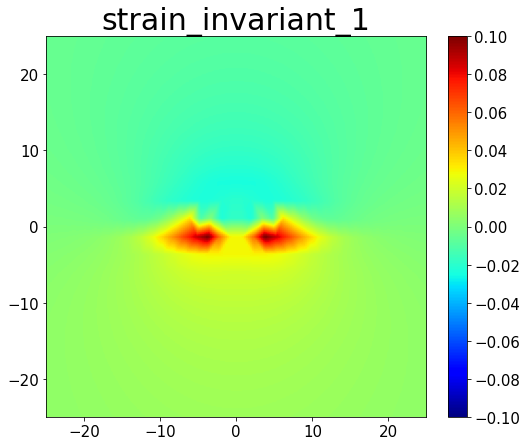

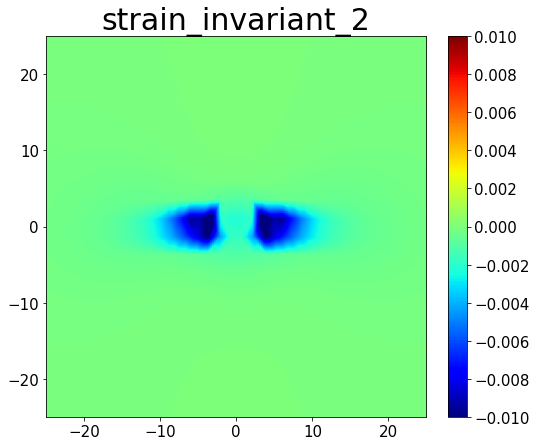

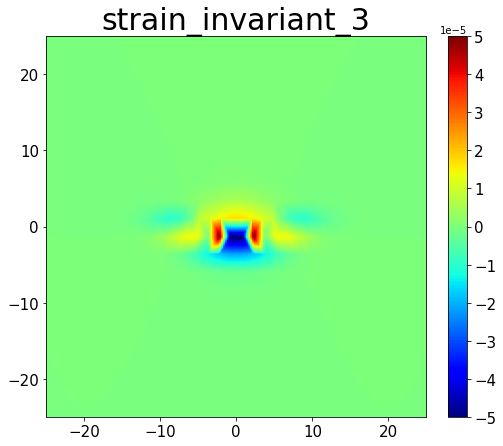

In [16]:
# Make contour plots for the strain invariants
intsum, avsum = am.plot.interpolate_contour(disl_system, 'strain_invariant_1', plotxaxis=[0,1,0], plotyaxis=[0,0,1],
                                            xlim=(-25,25), ylim=(-25,25), dots=False)

intsum, avsum = am.plot.interpolate_contour(disl_system, 'strain_invariant_2', plotxaxis=[0,1,0], plotyaxis=[0,0,1],
                                            xlim=(-25,25), ylim=(-25,25), dots=False)

intsum, avsum = am.plot.interpolate_contour(disl_system, 'strain_invariant_3', plotxaxis=[0,1,0], plotyaxis=[0,0,1],
                                            xlim=(-25,25), ylim=(-25,25), dots=False)

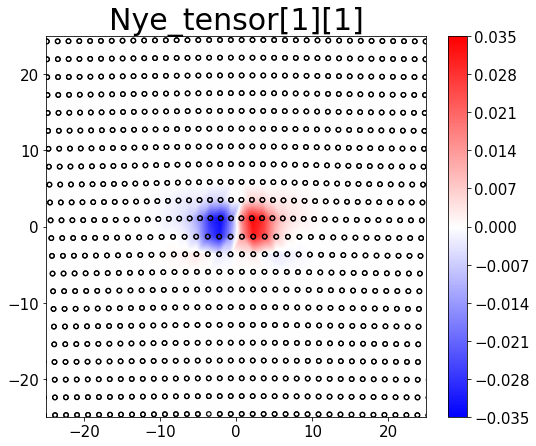

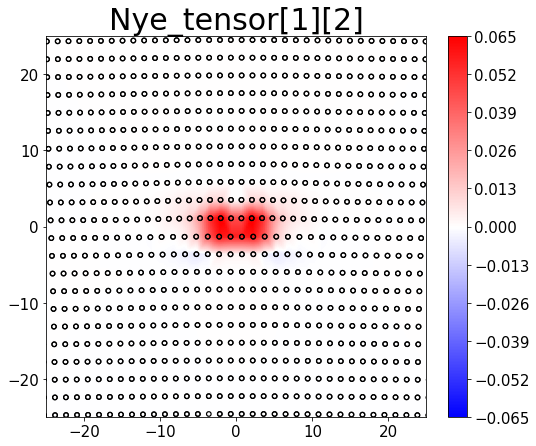

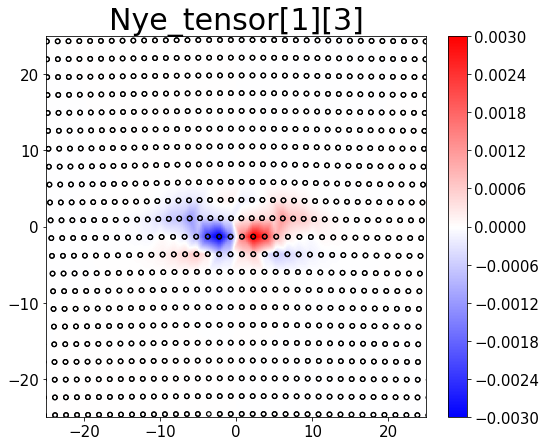

In [17]:
# plot Nye tensor components related to dislocations
intsum = np.empty(3)
intsum[0], avsum = am.plot.interpolate_contour(disl_system, 'Nye_tensor', index = [0,0],
                                               plotxaxis=[0,1,0], plotyaxis=[0,0,1],
                                               xlim=(-25,25), ylim=(-25,25), cmap='bwr')

intsum[1], avsum = am.plot.interpolate_contour(disl_system, 'Nye_tensor', index = [0,1],
                                               plotxaxis=[0,1,0], plotyaxis=[0,0,1],
                                               xlim=(-25,25), ylim=(-25,25), cmap='bwr')

intsum[2], avsum = am.plot.interpolate_contour(disl_system, 'Nye_tensor', index = [0,2],
                                               plotxaxis=[0,1,0], plotyaxis=[0,0,1],
                                               xlim=(-25,25), ylim=(-25,25), cmap='bwr')

Burgers vector estimate is obtained from the integer sums over the plots

In [18]:
print(f'actual Burgers vector:    [{burgers[0]: 7.4f}, {burgers[1]: 7.4f}, {burgers[2]: 7.4f}]')
print(f'estimated Burgers vector: [{intsum[0]: 7.4f}, {intsum[1]: 7.4f}, {intsum[2]: 7.4f}]')

actual Burgers vector:    [ 0.0000,  2.8638,  0.0000]
estimated Burgers vector: [-0.0041,  2.9144,  0.0015]


## 4. Differential displacement maps

Dislocation core structures can also be characterized using differential displacement maps as first used by [Vitek, Perrin and Bowen](https://doi.org/10.1080/14786437008238490). 

For every pair of neighboring atoms $\alpha$ and $\beta$, a differential displacement vector, $d_{i \alpha \beta}$ is computed as

$$ d_{i \alpha \beta} =  x_{i \alpha \beta} - X_{i \alpha \beta} $$

where $x_{i \alpha \beta}$ is the vector difference between atoms $\alpha$ and $\beta$ in the current (defect) configuration, and $X_{i \alpha \beta}$ is the vector difference between atoms $\alpha$ and $\beta$ in the reference (perfect crystal) configuration.  

Plots are then constructed where atomic positions are shown as circles with arrows representing components of $d_{i \alpha \beta}$. The arrows are centered halfway between the two atoms $\alpha$ and $\beta$ for which that particular $d_{i \alpha \beta}$ was computed.  For most variations, the direction of the arrows indicate the two atoms $\alpha$ and $\beta$ that $d_{i \alpha \beta}$ was computed for. Various plotting options and variations are described in more detail below.

*Update version 1.3.2* A DifferentialDisplacement class was introduced to make it easier to generate differential displacement maps and to allow for more options with different materials systems by separating the differential displacement calculation from the plotting.  The class is meant to replace the old differential_displacement function.

### 4.1 DifferentialDisplacement initialization/solve

Computing the differential displacement requires comparing the relative position vectors between a defect-free base system and a defect system for all pairs of neighbor atoms. Therefore, the calculation requires two compatible systems and a list of neighboring atoms.   

- __system_0__ (*atomman.system*) The defect-free base system to use.

- __system_1__ (*atomman.system*) The defect system to use.

- __neighbors__ (*atomman.NeighborList, optional*) The neighbor list to use.  

- __cutoff__ (*float, optional*) Cutoff distance for computing a neighbor list. If reference = 0, then system_0 will be used to generate the list. If reference = 1, then system_1 will be used to generate the list.

- __reference__ (*int, optional*) Indicates which of the two systems should be used for the plotting reference: 0 or 1. If 0, then system_0's atomic positions will be used for the calculation and neighbors should be for system_0.  If 1 (default), then system_1's atomic positions will be used for the calculation and neighbors should be for system_1.   

Either system_0 or system_1 can be used as the reference state for identifying neighbors and plotting atomic positions. 

- Using system_1 as the reference state will overlay the differential displacement vectors onto the relaxed atomic positions.  This provides insight for the dislocation both in terms of its atomic nature and core spreading. This is the more common representation, especially for dislocations with large edge components.

- Using system_0 as the reference state will overlay the differential displacement vectors onto a perfect crystal.  This indicates how the crystal needs to be deformed to introduce the dislocation.

In [19]:
# Note: the reference choice corresponds to the system for which the neighbor list was computed!

neighbors = disl_system.neighborlist(cutoff = 0.9*alat)
dd = am.defect.DifferentialDisplacement(base_system, disl_system, neighbors=neighbors, reference=1)

# or
#neighbors = base_system.neighborlist(cutoff = 0.9*alat)
#dd = am.defect.DifferentialDisplacement(base_system, disl_system, neighbors=neighbors, reference=0)

### 4.2 DifferentialDisplacement plotting

DifferentialDisplacement.plot() creates a differential displacement map as a matplotlib figure.  There are many options to help control what is plotted as well as give you options for tweaking how the plots look.
 
- __component__ (*str or array-like object*) Indicates the component(s) of the differential displacement to plot. Values of 'x', 'y', or 'z' will plot the component along that Cartesian direction.  A value of 'projection' will plot the differential displacement vectors as projected onto the plotting plane, thereby showing the two components perpendicular to the line direction.  If a 3D vector is given, then the component parallel to that direction will be used.
 
- __ddmax__ (*float or None*) The maximum differential displacement value allowed. Values will be kept between +-ddmax by wrapping values with larger absolute values around by adding/subtracting 2\*ddmax. Typically, this is set to be |b|/2, but can be defect-specific. For instance, fcc a/2<110> dislocations and basal hcp dislocations are typically plotted with ddmax=|b|/4.  If set to None, then no wrapping is done.

- __plotxaxis__ (*str or array-like object, optional*) Indicates the Cartesian direction associated with the system's atomic coordinates to align with the plotting x-axis.  Values are either 3D unit vectors, or strings 'x', 'y', or 'z' for the Cartesian axes directions.  plotxaxis and plotyaxis must be orthogonal.  Default value is 'x' = \[1, 0, 0\].
 
- __plotyaxis__ (*str or array-like object, optional*) Indicates the Cartesian direction associated with the system's atomic coordinates to align with the plotting y-axis.  Values are either 3D unit vectors, or strings 'x', 'y', or 'z' for the Cartesian axes directions.  plotxaxis and plotyaxis must be orthogonal.  Default value is 'y' = \[0, 1, 0\].
 
- __xlim__ (*tuple, optional*) The minimum and maximum coordinates along the plotting x-axis to include in the fit.  Values are taken in the specified length_unit. If not given, then the limits are set based on min and max atomic coordinates along the plotting axis.
 
- __ylim__ (*tuple, optional*) The minimum and maximum coordinates along the plotting y-axis to include in the fit.  Values are taken in the specified length_unit. If not given, then the limits are set based on min and max atomic coordinates along the plotting axis.
 
- __zlim__ (*tuple, optional*) The minimum and maximum coordinates normal to the plotting axes (i.e. plotxaxis X plotyaxis) to include in the fit.  Values are taken in the specified length_unit.  The optimum zlim should encompass only a single periodic slice.  If not given, then the limits are set based on min and max atomic coordinates along the axis.

- __arrowscale__ (*float, optional*) Scaling factor for the magnitude of the differential displacement arrows.  Default value is 1: no scaling, vectors are in units of length. For major components, this is often set such that the max differential displacement compoent after wrapping (see normfactor) is scaled to the distance between the atom pairs in the plot.  For minor components, this is often set to a large value simply to make the components visible.
 
- __arrowwidth__ (*float, optional*) Scaling factor to use for the width of the plotted arrows. Default value is 0.005 = 1/200.
 
- __use0z__ (*bool, optional*) If False (default), the z coordinates from the reference system will be used for zlim and atomcmap colors. If True, the z coordinates will be used from system0 even if system1 is the reference system.
 
- __atomcolor__ (*str or list, optional*) Matplotlib color name(s) to use to display the atoms.  If str, that color will be assigned to all atypes.  If list, must give a color value or None for each atype.  Default value (None) will use cmap instead. Note: atomcolor and atomcmap can be used together as long as exactly one color or cmap is given for each unique atype.
 
- __atomcmap__ (*str or list, optional*) Matplotlib colormap name(s) to use to display the atoms.  Atoms will be colored based on their initial positions and scaled using zlim. If str, that cmap will be assigned to all atypes.  If list, must give a cmap value or None for each atype.  Default value (None) will use 'hsv' cmap.  Note: atomcolor and atomcmap can be used together as long as exactly one color or cmap is given for each unique atype.
 
- __atomsize__ (*float, optional*) The circle radius size to use for the plotted atom positions in units of length.  Default value is 0.5.
 
- __figsize__ (*float or tuple, optional*) Specifies the size of the figure to create in inches.  If a single value is given, it will be used for the figure's width, and the height will be scaled based on the xlim and ylim values.  Alternatively, both the width and height can be set by passing a tuple of two values, but the plot will not be guaranteed to be "regular" with respect to length dimensions.
            
Returns

- (*matplotlib.Figure*) The generated figure.  This is returned to allow users to further modify it after creation.


#### 4.2.1 Common plotting variations

Plot has a large number of parameters to allow for a wide range of variations and to give users the ability to tinker with the plots to make them look better if needed.

As the differential displacement values are 3D vectors, the plots focus on showing one or two components

- 'x', 'y', and 'z' are the components along the three Cartesian directions.
- Any other Cartesian vector can be specified to see components along it.  It is especially useful to be able to plot the component parallel to the Burgers vector for mixed dislocations.
- 'projection' plots the projection of the differential displacement vectors onto a plane perpendicular to the dislocation's line direction. Unlike the other options, the direction of the arrows correspond to the vector values rather than the positions of the two atoms for which the vector was computed for.  

Values are typically normalized to be within a range of $\pm$ ddmax by adding/subtracting 2\*ddmax to values outside the range.  
- ddmax = $\frac{|b_i|}{2}$ is typically used for full compact dislocations. As a displacement of $b_i$ corresponds to a full lattice shift back to a perfect crystal, this choice ensures that only the region associated with the dislocation core will have large differential displacement values.

- ddmax = $\frac{|b_i|}{4}$ is typically used for fcc $\frac{a}{2}$<$1\bar{1}0$>{111} and hcp $\frac{a}{3}$<$11\bar{2}0$>{0001} dislocations. These dislocations tend to split into partials separated by a stacking fault width. This choice of ddmax means that the differential displacement parallel to the Burgers vector is near zero for the perfect crystal and the stacking fault, making it easy to see where the partial dislocation cores are located. 

Most of the other method parameters are associated with making the plots look good. The best suggestion is to create one plot, then tinker with the plotting parameters to improve how it looks.

Define common plotting parameters.

In [20]:
ddmax = np.linalg.norm(burgers) / 4   # a/2<110> fcc dislocations use |b|/4

# Set dict of keyword parameter values (just to make settings same for all plots below)
params = {}
params['plotxaxis'] = 'y'
params['plotyaxis'] = 'z'
params['xlim'] = (-20, 20)
params['ylim'] = (-5, 5)
params['zlim'] = (-0.01, alat*6**0.5 / 2 + 0.01) # Should be one periodic width (plus a small cushion)
params['figsize'] = 10         # Only one value as the other is chosen to make plots "regular"
params['arrowwidth'] = 1/50    # Made bigger to make arrows easier to see
params['arrowscale'] = 2.4     # Typically chosen to make arrows of length ddmax touch the corresponding atom circles

#### 4.2.2 The Cartesian components

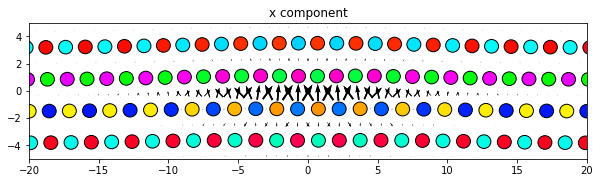

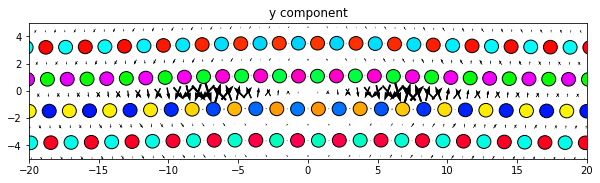

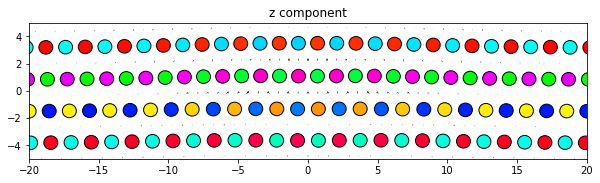

In [21]:
dd.plot('x', ddmax, **params)
plt.title('x component')
plt.show()

dd.plot('y', ddmax, **params)
plt.title('y component')
plt.show()

dd.plot('z', ddmax, **params)
plt.title('z component')
plt.show()

#### 4.2.3 Parallel to Burgers (or any other Cartesian vector)

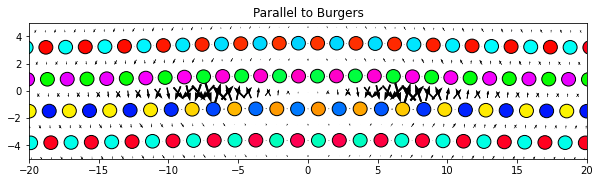

In [22]:
# Set ddmax to be 1/4 the magnitude of the Burgers vector (see above)
ddmax = np.linalg.norm(burgers)/4

dd.plot(burgers, ddmax, **params)
plt.title('Parallel to Burgers')
plt.show()


#### 4.2.4 Radial

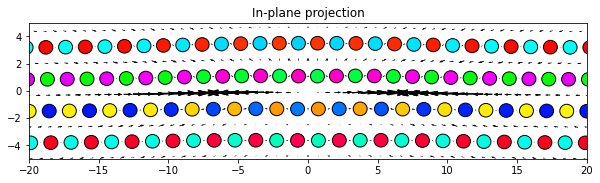

In [23]:
# Set ddmax to be 1/4 the magnitude of the Burgers vector (see above)
ddmax = np.linalg.norm(burgers)/4

dd.plot('projection', ddmax, **params)
plt.title('In-plane projection')
plt.show()

### 4.3 Raw differential displacement data

The raw data used to generate the plots can also be retrieved as attributes of the DifferentialDisplacement objects.

- __ddvectors__ are the computed differential displacement vectors for each pair of neighbor atoms. Note that these are the full raw values computed during the class initialization and therefore have not been normalized with ddmax.

- __arrowcenters__ are the center positions for each of the differential displacement vector arrows. These points also correspond to the midpoints between the pair of neighbor atoms used to compute the differential displacement vector. 

- __arrowuvectors__ are the unit vectors indicating the direction of the differential displacement vector arrows used by all component options except for 'projection'. 

In [24]:
print(dd.ddvectors.shape)
print(dd.ddvectors)

(387340, 3)
[[ 0.00030753  0.00574007  0.0056176 ]
 [ 0.00015473  0.00286493  0.00279437]
 [-0.0001565  -0.00285422 -0.00276553]
 ...
 [-0.00012418  0.00269864 -0.00278591]
 [-0.00012418  0.00269864 -0.00278591]
 [-0.00025094  0.00539228 -0.00554786]]


In [25]:
print(dd.arrowcenters.shape)
print(dd.arrowcenters)

(387340, 3)
[[   2.4866357  -112.592277   -109.13996141]
 [   1.24650369 -113.30966101 -109.14137303]
 [   3.72645929 -114.74441346 -109.14415298]
 ...
 [   5.38094613  108.99060147 -118.48030553]
 [   7.86105735  108.99060147 -118.48030553]
 [   6.62093836  109.70789473 -118.48168651]]


In [26]:
print(dd.arrowuvectors.shape)
print(dd.arrowuvectors)

(387340, 3)
[[ 1.07171033e-04  9.99998078e-01  1.95767095e-03]
 [-8.65578157e-01  5.00772906e-01  9.75316053e-04]
 [ 8.65579630e-01 -5.00770378e-01 -9.65254013e-04]
 ...
 [-8.65627722e-01  5.00687230e-01 -9.72312841e-04]
 [ 8.65605989e-01  5.00724801e-01 -9.72385803e-04]
 [-8.74616512e-05  9.99998127e-01 -1.93360212e-03]]
